In [2]:
# File: GridSensorShap.py
import numpy as np
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
import onnxruntime as ort
import os

c:\Users\Owner\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# === CONFIGURATION ===
BIN_PATH = "foodAgentObs.bin"  # update this path
ONNX_PATH = "Food_with_logits.onnx"
ACTIONS_PATH = "foodAgentObs_actions.npy"
GRID_WIDTH = 40
GRID_HEIGHT = 40
TAG_COUNT = 5  # food, agent, wall, bad food, frozen agent
OBS_SIZE = GRID_WIDTH * GRID_HEIGHT * TAG_COUNT  # 8000

In [4]:
# === TAG DEFINITIONS ===
TagLabels = ["Food", "Agent", "Wall", "BadFood", "FrozenAgent"]

# === SEMANTIC GROUPING ===
SemanticGroups = {f"{tag} Detected": [] for tag in TagLabels}
for i in range(GRID_WIDTH * GRID_HEIGHT):
    base = i * TAG_COUNT
    for j, tag in enumerate(TagLabels):
        SemanticGroups[f"{tag} Detected"].append(base + j)


In [5]:
# === LOAD OBSERVATIONS ===
def load_observations(path):
    data = np.fromfile(path, dtype=np.float32)
    remainder = data.size % OBS_SIZE
    if remainder != 0:
        print(f"Trimming {remainder} extra floats")
        data = data[:-remainder]
    reshaped = data.reshape(-1, OBS_SIZE)
    mask = np.isfinite(reshaped).all(axis=1)
    return reshaped[mask]

X = load_observations(BIN_PATH)
print(f"Loaded {X.shape[0]} valid observations")

Loaded 34950 valid observations


In [6]:
# === LOAD MODEL ===
session = ort.InferenceSession(ONNX_PATH)
input_names = [i.name for i in session.get_inputs()]
output_names = [o.name for o in session.get_outputs()]

# Determine action mask shape (if present)
mask_shape = session.get_inputs()[-1].shape
mask_size = mask_shape[1] if len(mask_shape) > 1 else 1

# Create dummy input to infer output shapes
dummy_input = {
    input_names[0]: np.zeros((1, TAG_COUNT, GRID_WIDTH, GRID_HEIGHT), dtype=np.float32),
    input_names[1]: np.ones((1, mask_size), dtype=np.float32)
}
outputs = session.run(None, dummy_input)

# Identify all outputs with shape (1, N)
logits_names = [name for name, out in zip(output_names, outputs) if len(out.shape) == 2 and out.shape[0] == 1]
print("✅ Found outputs:", logits_names)

✅ Found outputs: ['continuous_actions', 'deterministic_continuous_actions', 'discrete_actions', 'discrete_action_output_shape', '73', '/_discrete_distribution/Softmax_output_0']


In [7]:
# === PREDICT FUNCTION ===
def predict_fn(X, output_name):
    reshaped_input = X.reshape(-1, TAG_COUNT, GRID_WIDTH, GRID_HEIGHT).astype(np.float32)
    return session.run([output_name], {
        input_names[0]: reshaped_input,
        input_names[1]: np.ones((reshaped_input.shape[0], mask_size), dtype=np.float32)
    })[0]

In [8]:
# ==== NEW ==== helper: ensure we always get one row per observation
def safe_predict(X_full, output_name, batch_size=128):
    """
    Runs the model; if the tensor has a fixed batch dimension (1) it automatically
    falls back to micro‑batching so the returned array has the same number of rows
    as X_full.
    """
    Y = predict_fn(X_full, output_name)
    if Y.shape[0] == X_full.shape[0]:
        return Y                                  # dynamic batch dimension – nothing to do

    # Static batch dimension – loop in blocks
    chunks = []
    for start in range(0, X_full.shape[0], batch_size):
        end = start + batch_size
        chunks.append(predict_fn(X_full[start:end], output_name))
    return np.concatenate(chunks, axis=0)

In [24]:
# === LOAD ACTIONS TAKEN ===
actions_taken = np.load(ACTIONS_PATH)  # shape: (N,)
cont_actions = [action[:3] for action in actions_taken]  # Compute argmax for the first 3 indices
disc_actions = [action[3:] for action in actions_taken]

print(f"Actions taken shape: {actions_taken.shape}")
print(f"Continuous actions shape: {np.array(cont_actions).shape}")
print(f"Discrete actions shape: {np.array(disc_actions).shape}")
print(f"Loaded {actions_taken.shape[0]} actions taken")
print(f"{actions_taken}")

Actions taken shape: (34950, 4)
Continuous actions shape: (34950, 3)
Discrete actions shape: (34950, 1)
Loaded 34950 actions taken
[[-0.3295151   0.02272185  0.80165619  1.        ]
 [-0.29294324  0.09652141  0.15822999  0.        ]
 [-0.14114501 -0.42244968 -0.47847581  1.        ]
 ...
 [ 0.18352108  0.40991536  0.03587807  0.        ]
 [-0.47269213 -0.13175014 -0.83532518  1.        ]
 [-0.0684768   0.23012252  0.39100036  1.        ]]



✅ Kept 34950 clean observations for output 'continuous_actions'
🎯 Training surrogate for continuous_actions - Output 0


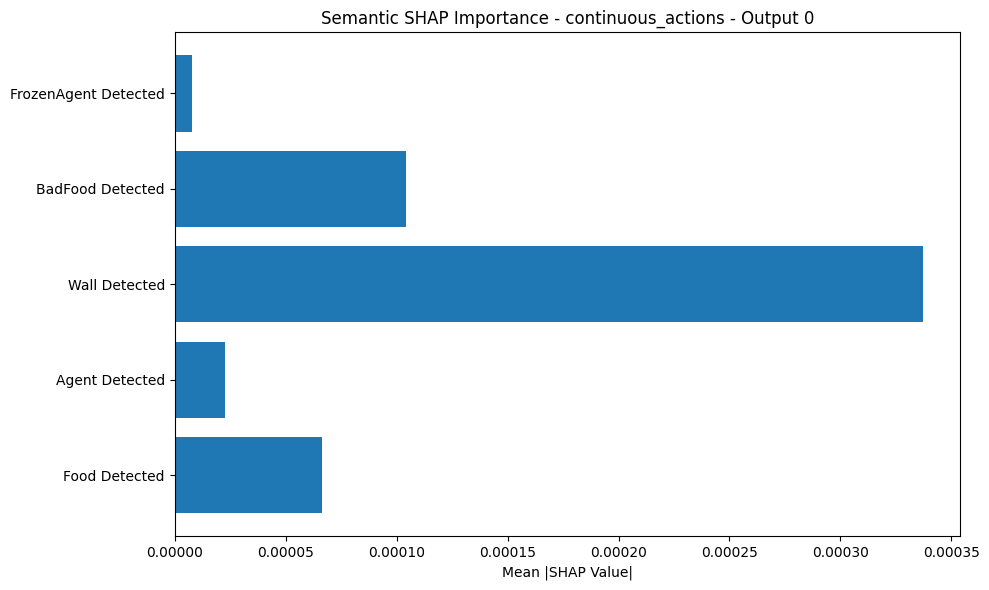

🎯 Training surrogate for continuous_actions - Output 1


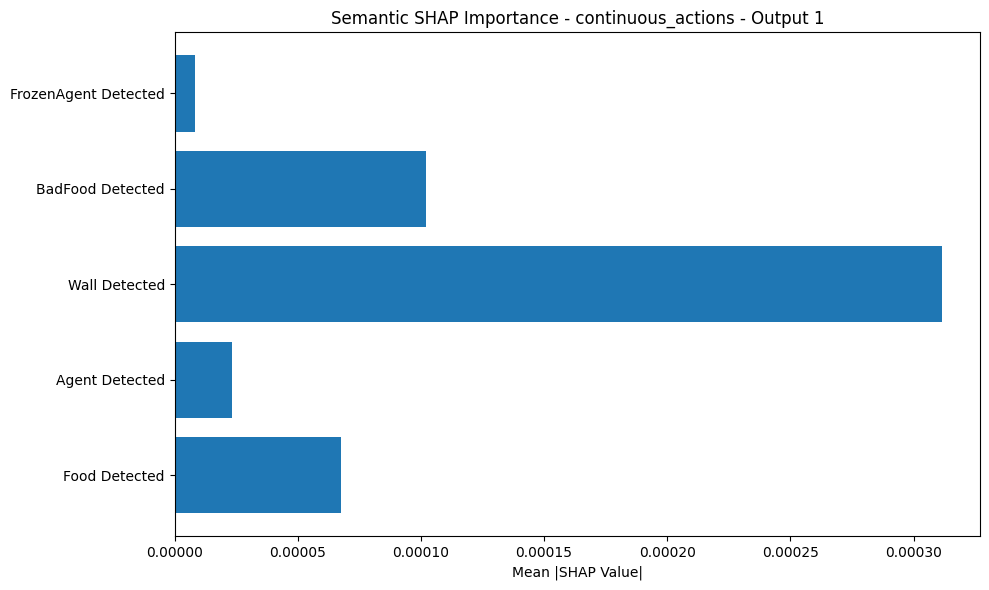

🎯 Training surrogate for continuous_actions - Output 2


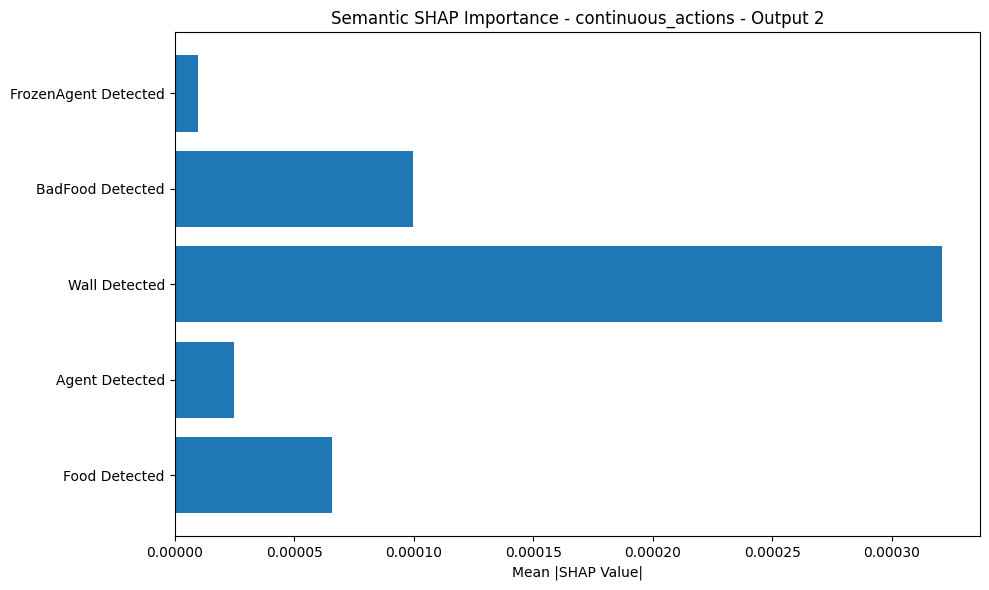


✅ Kept 34950 clean observations for output '/_discrete_distribution/Softmax_output_0'
🎯 Training surrogate for /_discrete_distribution/Softmax_output_0 - Output 0


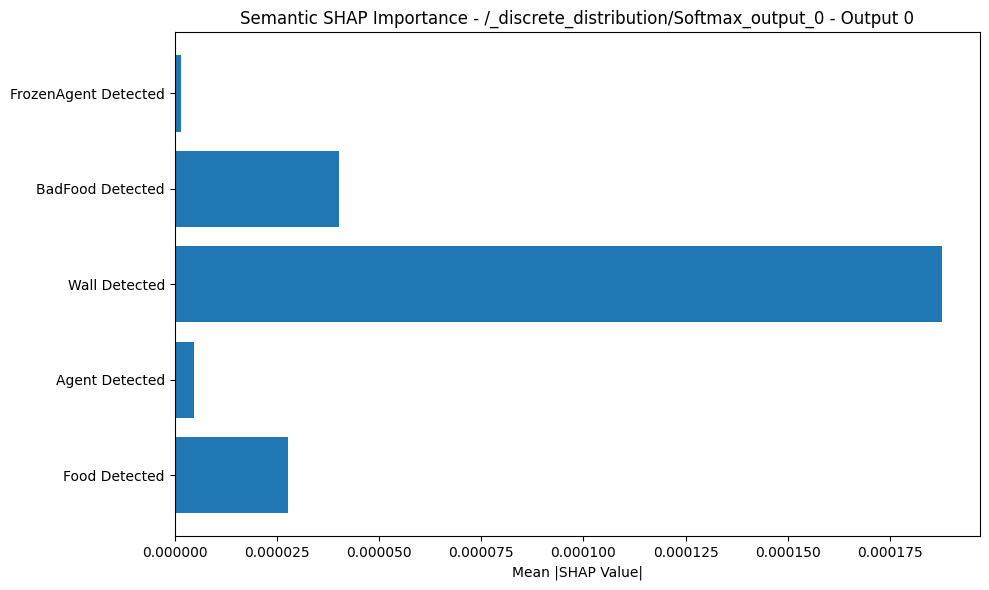

🎯 Training surrogate for /_discrete_distribution/Softmax_output_0 - Output 1


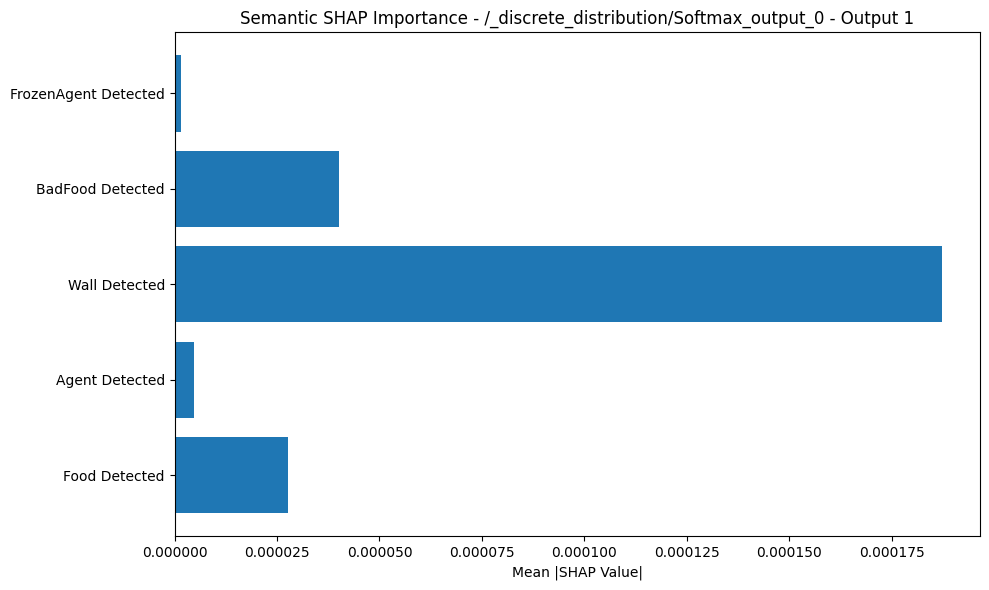


✅ SHAP analysis complete for all outputs.


In [ ]:
# === ANALYSE EACH OUTPUT ===
os.makedirs("shap_plots", exist_ok=True)

semantic_shap_per_ob = []

for logits_name in logits_names:
    if logits_name not in ['continuous_actions', '/_discrete_distribution/Softmax_output_0']:
        continue

    # ==== CHANGED ==== use safe_predict instead of predict_fn
    Y = safe_predict(X, logits_name)

    valid_rows = np.all(np.isfinite(Y), axis=-1)
    X_clean = X[valid_rows]
    Y_clean = Y[valid_rows]
    print(f"\n✅ Kept {X_clean.shape[0]} clean observations for output '{logits_name}'")

    for i in range(Y_clean.shape[1]):
        print(f"🎯 Training surrogate for {logits_name} - Output {i}")
        model = xgb.XGBRegressor(n_estimators=200, max_depth=15)
        model.fit(X_clean, Y_clean[:, i])
        explainer = shap.Explainer(model)
        shap_values = explainer(X_clean)

        # Group by semantic categories
        group_names = []
        group_scores = []
        for name, indices in SemanticGroups.items():
            score = np.abs(shap_values.values[:, indices]).mean()
            group_names.append(name)
            group_scores.append(score)

        # === PLOT ===
        plt.figure(figsize=(10, 6))
        plt.barh(group_names, group_scores)
        plt.xlabel("Mean |SHAP Value|")
        plt.title(f"Semantic SHAP Importance - {logits_name} - Output {i}")
        plt.tight_layout()
        filename = f"shap_plots/shap_{logits_name.replace('/', '_')}_output{i}.png"
        plt.savefig(filename, dpi=300)
        plt.show()

print("\n✅ SHAP analysis complete for all outputs.")

In [10]:
print(Y_clean.shape)

(34950, 2)
